In [4]:
import subprocess
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import os
import random
import json
from functools import reduce
from IPython.display import display


In [5]:
ROOT = os.getcwd()
TRAIT_FOLDER = os.path.join(ROOT, 'traits')
test_key_file = '/home/nico/.ssh/id_ed25519'

In [6]:
COLORS = {
    'black': '#000000',
    'blue': '#0000FF',
    'gray': '#808080',
    'green': '#008000',
    'purple': '#800080',
    'red': '#FF0000',
    'white': '#FFFFFF'
}

UNIQUE_COLORS = {
    'black': '#000000',
    'white' : '#FFFFFF',
    'electricblue' : '#1974D2',
    'coral': '#FF7F50',
    'firebrick': '#B22222',
    'hotpink': '#FF69B4',
    'lemonchiffon': '#FFFACD'
}

In [7]:
def make_color_files(colors, out_file='colors', height=1000, width=1000):
    for color in colors:
        img = Image.new('RGB', size=(width, height), color=colors[color])
        img.save(os.path.join(ROOT, out_file, str(color)+'.png'), 'PNG')

In [8]:
def get_key_str(key_file, hash_algo):
    res = subprocess.run(['ssh-keygen', '-lvf', key_file], stdout=subprocess.PIPE)
    out = res.stdout
    key_str = '\n'.join(out.decode('utf-8').split('\n')[1:])
    return key_str

def get_key_img(key_metadata, key_file=None, width=1000, height=1000):
    if key_file:
        key_str = get_key_str(key_file, key_metadata[hash_algo])
    else:
        key_str = generate_key_str()
        key_str = key_metadata['key_string']
    img = Image.new('RGB', (width, height), color=key_metadata['backgroud'])
    font = ImageFont.truetype('./terminus-ttf-4.49.1/TerminusTTF-4.49.1.ttf', 75)
    w, h = draw.textsize(key_str, font=font)
    draw.text(((width - w)/2, (height - h)/2), key_str, font=font, fill=key_metadata["fill"])
    img.save(os.path.join(ROOT, 'output', key_metadata['name'].split('_')[-1]+'.png'), 'PNG')
    return img

# Metadata Generation

In [9]:
def map_traits(folder):
    return [elt.split('.')[0] for elt in os.listdir(os.path.join(ASSET_FOLDER, folder))]

def get_funweights(trait):
    return [100 for _ in range(len(os.listdir(os.path.join(ASSET_FOLDER, trait))))]

def item_to_code(item):
    return reduce(lambda x, y: x + y, [trait_to_code(item, trait_name) for trait_name in trait_names])
    
def trait_to_code(item, trait_name):
    code = str(traits_to_idx[trait_name][item[trait_name]])
    return code if len(code) == 2 else '0'+ code
    
def is_new_item(new_code, collection_code):
    for i in range(len(collection_code)):
        if new_code == collection_code[i]:
            return False
    return True

def is_valid_item(item):
    """ 
    Write rules that collection must follow 
    eg : if not rule(item): return False
    """
    #if hero['ear_accessory'] == 'sayan_scooter' and hero['eye_accessory'] != 'none':
    #    return False
    if item['background'] == item['fill']:
        return False
    return True

def generate_item(dictionaries, traits=None):
    item = {}
    is_valid = False
    while not is_valid:
        for trait_name in dictionaries[0]:            
            item[trait_name] = random.choices(dictionaries[0][trait_name], dictionaries[1][trait_name])[0]
        is_valid = is_valid_item(item)
    return item

def generate_collection(dictionaries, collection_size=10000):
    collection = []
    collection_code = []
    for i in range(collection_size):
        new_item = generate_item(dictionaries)
        new_code = item_to_code(new_item)
        if i: 
            while not is_new_item(new_code, collection_code):
                new_item = generate_item(dictionaries)
                new_code = item_to_code(new_item)
        collection.append(new_item)
        collection_code.append(new_code)
    return collection, collection_code

def generate_key_str(algo_name, out_file):
    if algo_name == 'rsa':
        res = subprocess.run(['ssh-keygen', '-t', 'rsa', '-b', '4096', '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
    elif algo_name == 'ecdsa':
        res = subprocess.run(['ssh-keygen', '-t', 'ecdsa', '-b', '521', '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
    else:
        res = subprocess.run(['ssh-keygen', '-t', algo_name, '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
    out = res.stdout
    key_str = '\n'.join(out.decode('utf-8').split('\n')[-12:])
    return key_str

In [10]:
COLLECTION_SIZE = 100
COMMON = 100
UNCOMMON = 50
RARE = 25
EPIC = 10
LEG = 3

ROOT = os.getcwd()
ASSET_FOLDER = os.path.join(ROOT, 'traits')
assert os.path.exists(ASSET_FOLDER)
OUTPUT_FOLDER = os.path.join(ROOT, 'assets')
assert os.path.exists(OUTPUT_FOLDER)
trait_names = os.listdir(TRAIT_FOLDER)
traits_to_idx = {trait_name : {trait_instance[:-4]: i for i, trait_instance in enumerate(os.listdir(os.path.join(ASSET_FOLDER, trait_name)))} for trait_name in trait_names}
trait_dict = {trait_name: trait_list for trait_name, trait_list in zip(trait_names, map(map_traits, trait_names))}
funweights = {trait_name: get_funweights(trait_name) for trait_name in trait_names}
collection, collection_codes = generate_collection(dictionaries=[trait_dict, funweights], collection_size=COLLECTION_SIZE)


In [11]:
trait_dict

{'algo': ['dsa', 'ecdsa', 'ed25519', 'rsa'],
 'background': ['black',
  'coral',
  'electricblue',
  'firebrick',
  'hotpink',
  'lemonchiffon',
  'white'],
 'fill': ['black', 'blue', 'gray', 'green', 'purple', 'red', 'white']}

---

In [15]:
class NFT:
    def __init__(self, file=None, traits=None, idx=None):
        self.metadata = self.load_metadata_from_file(file)
        self.set_idx(idx)
        self.width = 1000
        self.height = 1000
        # self.update_name_from_idx()
        # self.update_image_from_idx()
        # self.update_uri()
        # self.dump_metadata()
        
    def set_idx(self, idx):
        if not idx and idx != 0:
            self.idx = 'X'
        elif not isinstance(idx, str):
            self.idx = str(idx)
        else:
            self.idx = idx
    
    def get_idx(self):
        return idx
    
    def update_image_from_idx(self):
        self.set_trait('image', f'{self.get_idx()}.png')
        #if not self.image_exists():
        #    print('Generating image based on metadata...')
        #    self.make_image()
        self.image = self.make_image()
    
    def update_uri(self):
        self.metadata["properties"]["files"][0]["uri"] = self.get_image()
        
    def image_exists(self):
        if not os.path.exists(item_nft.get_trait('image')):
            return False
        return True
        
    def make_image(self):
        return 
    
    def load_metadata_from_file(self, file):
        if not file:
            return self.load_metadata_template()
        with open(file, 'r') as f:
            return json.load(f)
    
    @staticmethod
    def load_metadata_template(file=None, share=True):
        if not file:
            if share:
                with open(os.path.join(ROOT, 'share_template.json'), 'r') as ff:
                    return json.load(ff)
            else:
                with open(os.path.join(ROOT, 'template.json'), 'r') as f:
                    return json.load(f)
        with open(file, 'r') as f:
            return json.load(f)
    
    def set_attribute(self, attribute_trait, target):
        if not self.metadata['attribute']:
            raise ValueError('no found attributes')
        else:
            self.metadata['attributes'][attribute_trait] = target
    
    def get_attribute(self, attribute_trait=None):
        if not attribute_trait:
            return self.get_trait('attributes')
        return self.get_trait('attributes')[self.attribute_to_idx[attribute_trait]]["value"]
    
    def set_trait(self, trait, target):
        self.metadata[trait] = target
    
    def get_trait(self, trait):
        return self.metadata[trait]
    
    def update_attributes(self, traits):
        self.attribute_to_idx = {trait: i for i, trait in enumerate(traits)}
        attributes = [{"trait_type": str(trait), "value": str(traits[trait])} for trait in traits]
        self.set_trait('attributes', attributes)
    
    def update_name_from_idx(self, idx):
        self.set_trait('name', f'#{idx}')
    
    def get_image_path(self):
        return os.path.join(OUTPUT_FOLDER, self.get_trait('image'))

    def show_image(self):
        img = Image.open(self.get_image_path())
        img.show()
        
    def get_name(self):
        return self.get_trait('name')
    
    def get_image(self):
        return self.get_trait('image')
    
    def __repr__(self):
        return str(self.metadata)
    
    def dump_metadata(self, dest='assets'):
        with open(os.path.join(ROOT, dest, f'{self.get_idx()}.json'), 'w') as f:
            json.dump(self.metadata, f)
        

class SolKeyNFT(NFT):
    def __init__(self, file=None, traits=None, idx=None):
        super().__init__(file, traits, idx)
        self.update_attributes(traits)
        self.set_key_str()
        self.update_name_from_idx()
        self.update_image_from_idx()
        self.update_uri()
        self.dump_metadata()

    def set_key_str(self):
        self.key_str = self.generate_key_str()
    
    def get_key_str(self):
        return self.key_str
    
    def set_algo(self, target):
        self.set_attribute('algo', target)
    
    def set_background(self, target):
        self.set_attribute('background', target)
        
    def set_fill(self, target):
        self.set_attribute('fill', target)
    
    def get_algo(self):
        return self.get_attribute('algo')
    
    def get_background(self):
        return self.get_attribute('background')
        
    def get_fill(self):
        return self.get_attribute('fill')
        
    def update_name_from_idx(self):
        self.set_trait('name', f'SolKey #{self.get_idx()}')
    
    def generate_key_str(self):
        out_file = os.path.join(ROOT, 'keygen', f'key_{self.get_idx()}')
        algo_name = self.get_algo()
        if algo_name == 'rsa':
            res = subprocess.run(['ssh-keygen', '-t', 'rsa', '-b', '4096', '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
        elif algo_name == 'ecdsa':
            res = subprocess.run(['ssh-keygen', '-t', 'ecdsa', '-b', '521', '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
        else:
            res = subprocess.run(['ssh-keygen', '-t', algo_name, '-f', out_file, '-N', ' '], stdout=subprocess.PIPE)
        out = res.stdout
        key_str = '\n'.join(out.decode('utf-8').split('\n')[-12:])
        return key_str 

    def get_idx(self):
        return self.idx
    
    def make_image(self):
        key_str = self.get_key_str()
        img = Image.new('RGB', (self.width, self.height), color=UNIQUE_COLORS[self.get_background()])
        font = ImageFont.truetype(os.path.join(ROOT, 'style', 'terminus-ttf-4.49.1/TerminusTTF-4.49.1.ttf'), 75)
        draw = ImageDraw.Draw(img)
        w, h = draw.textsize(key_str, font=font)
        draw.text(((self.width - w)/2, (self.height - h)/2), key_str, font=font, fill=COLORS[self.get_fill()])
        
        img.save(os.path.join(OUTPUT_FOLDER, self.get_idx() + '.png'), 'PNG')
        return img


In [13]:
def draw_collection(collection):
    for i, item in enumerate(collection):
        nft = SolKeyNFT(traits=item, idx=i)
        img = Image.open(nft.get_image_path())
        display(img.resize((300, 300), Image.NEAREST))

            

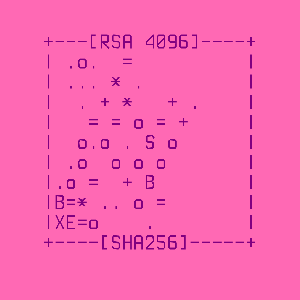

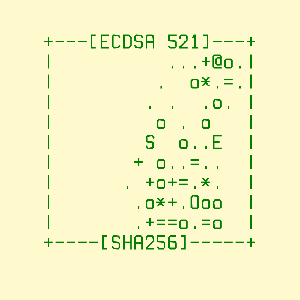

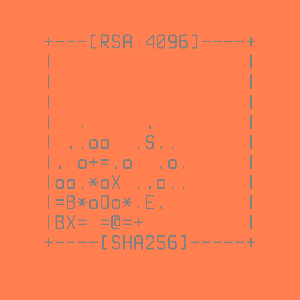

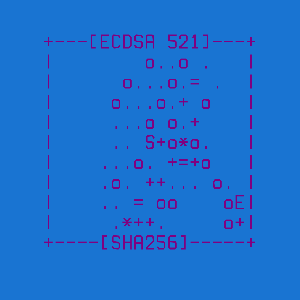

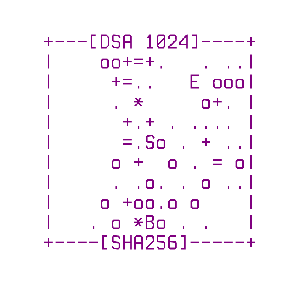

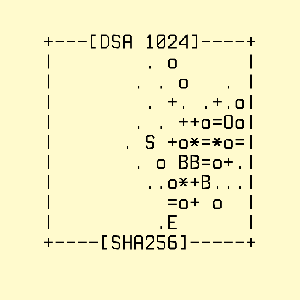

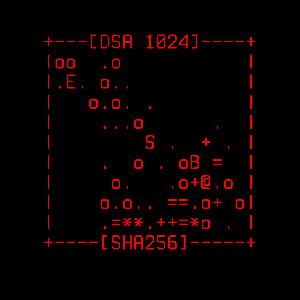

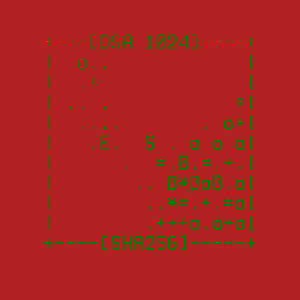

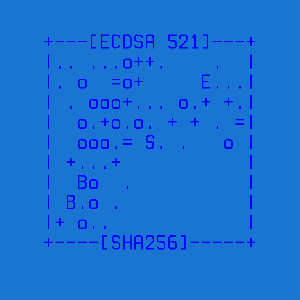

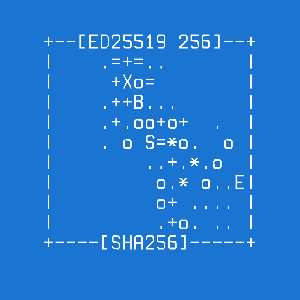

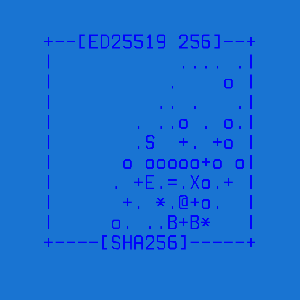

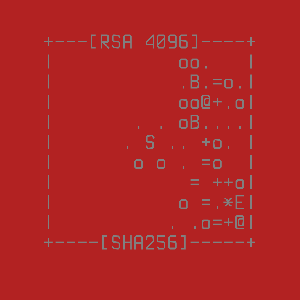

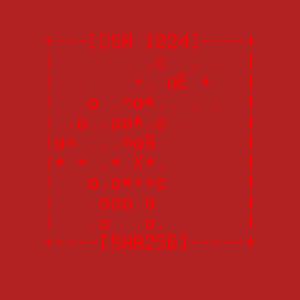

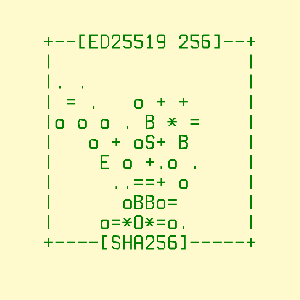

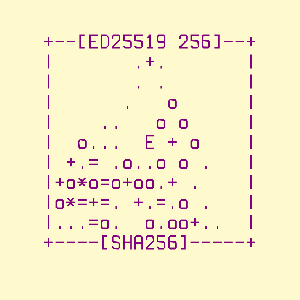

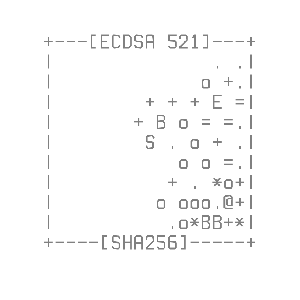

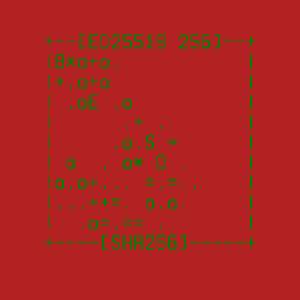

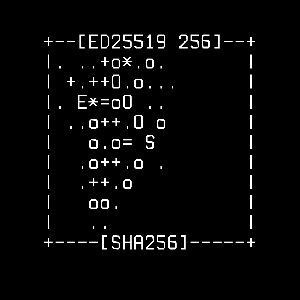

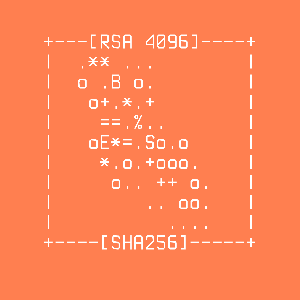

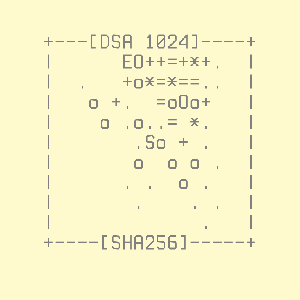

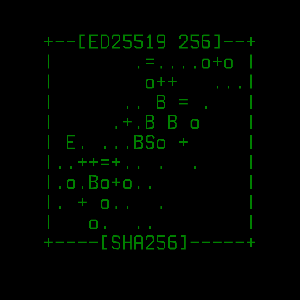

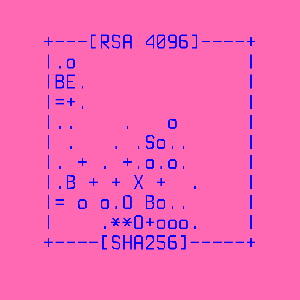

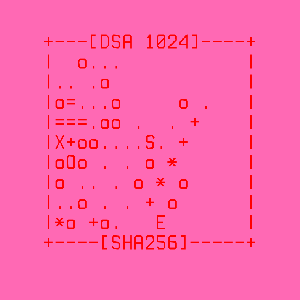

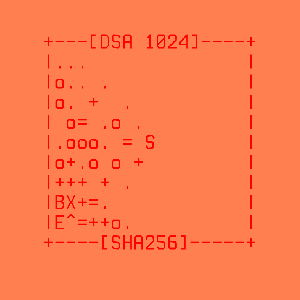

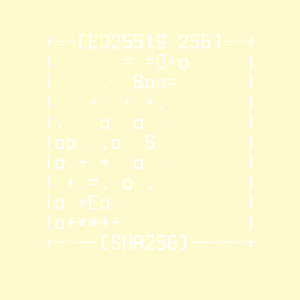

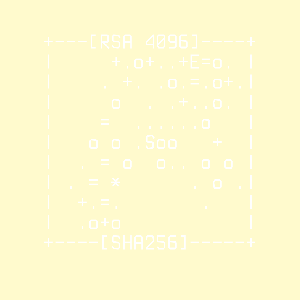

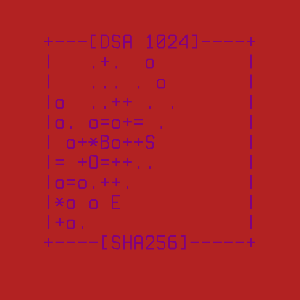

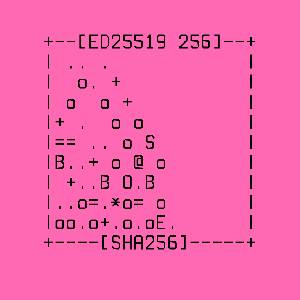

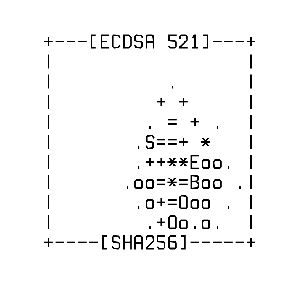

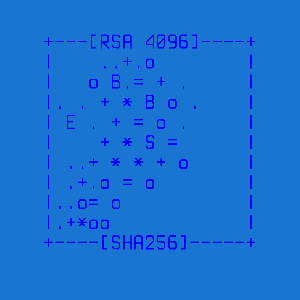

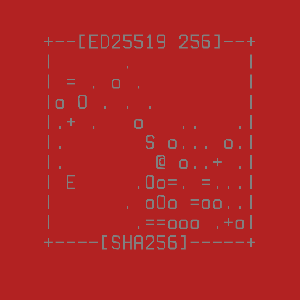

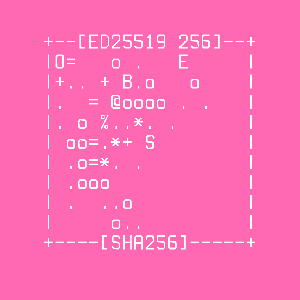

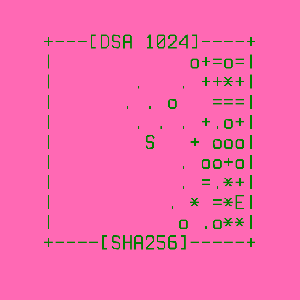

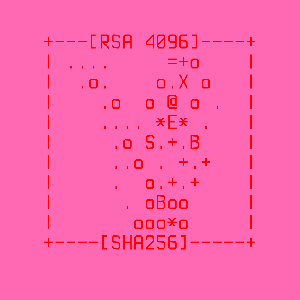

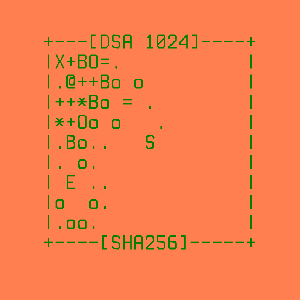

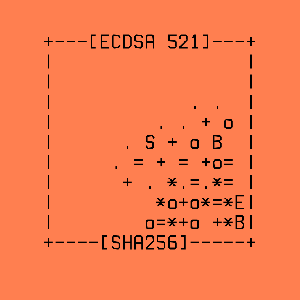

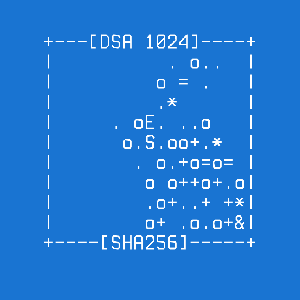

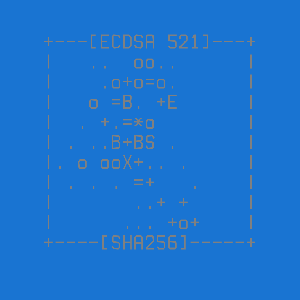

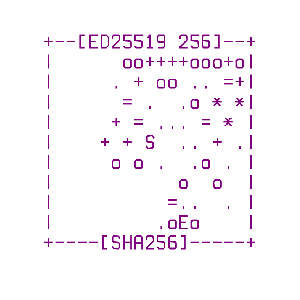

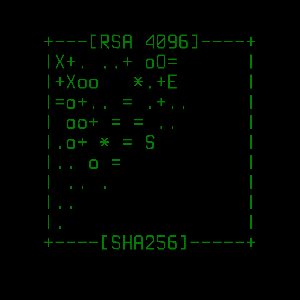

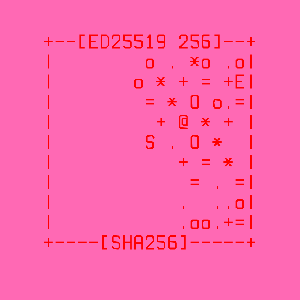

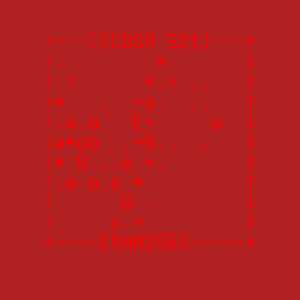

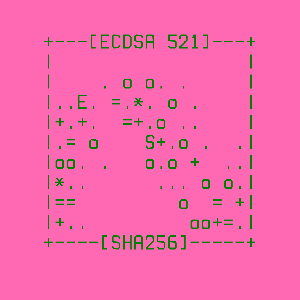

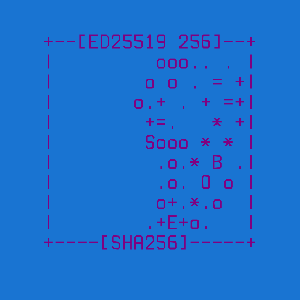

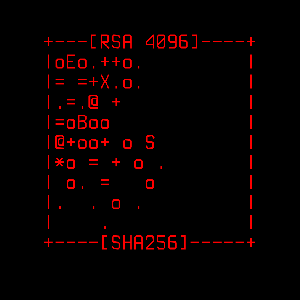

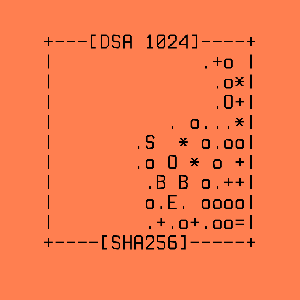

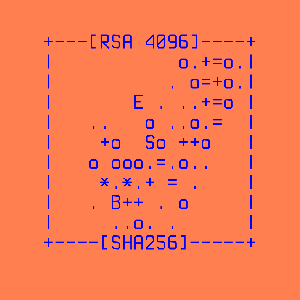

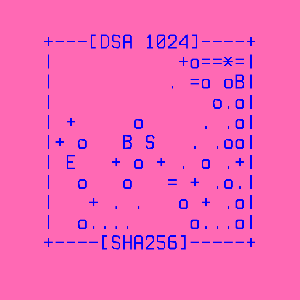

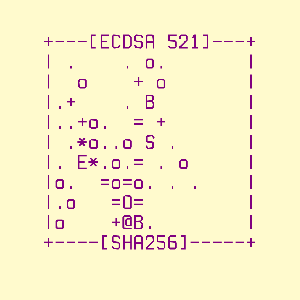

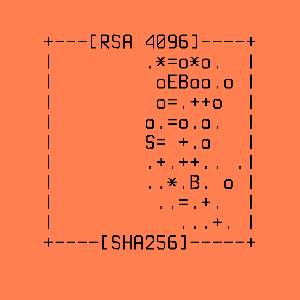

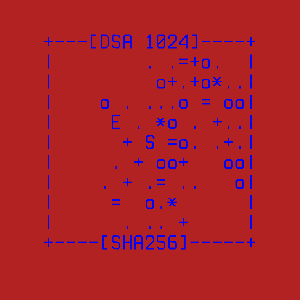

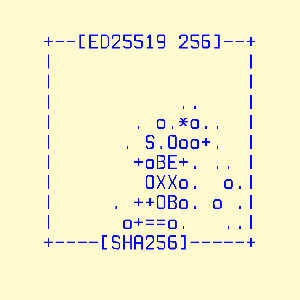

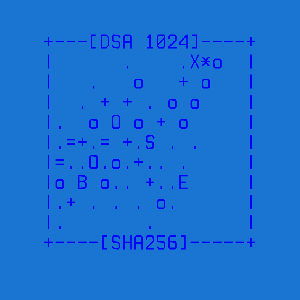

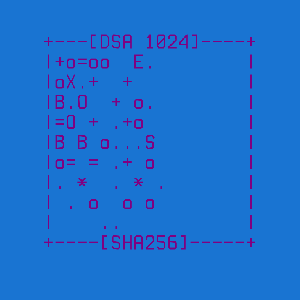

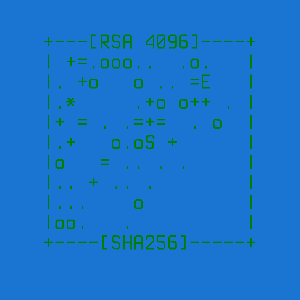

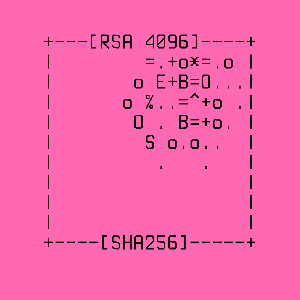

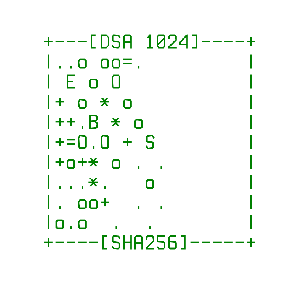

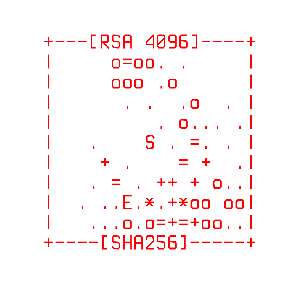

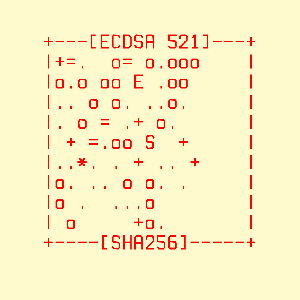

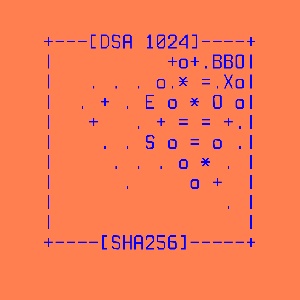

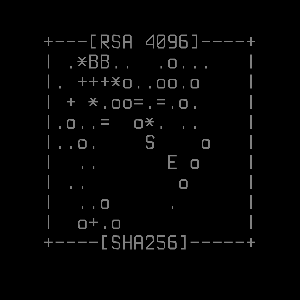

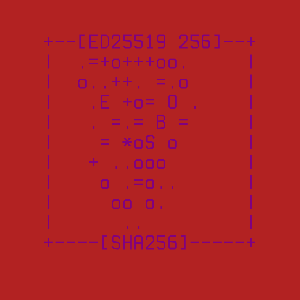

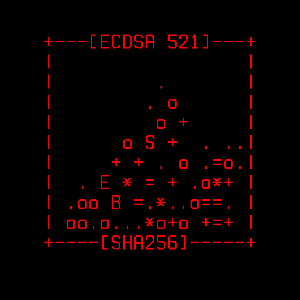

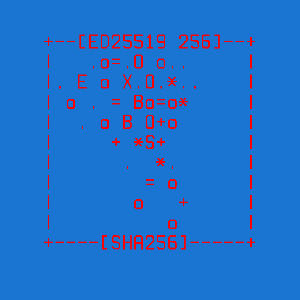

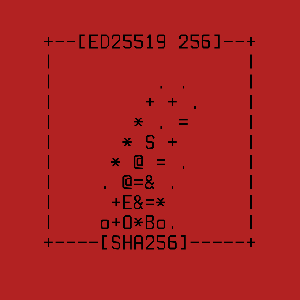

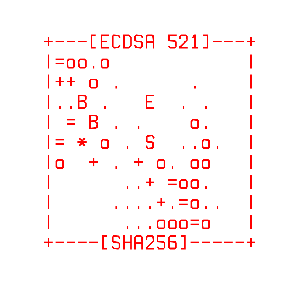

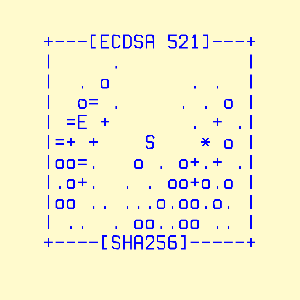

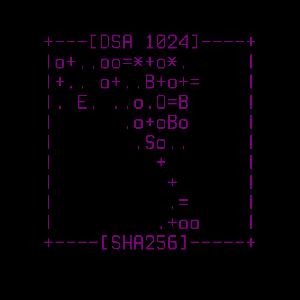

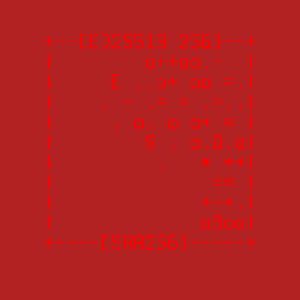

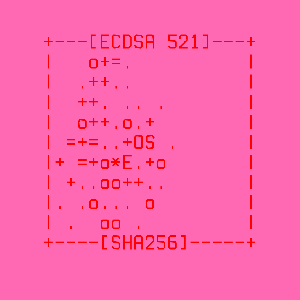

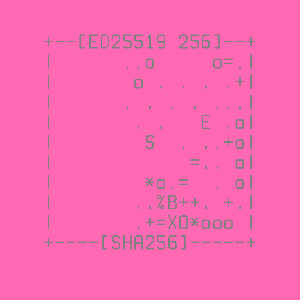

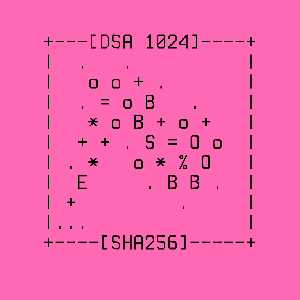

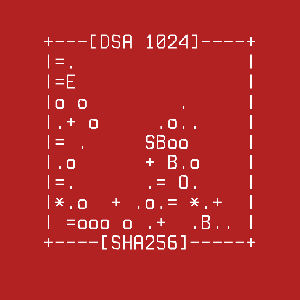

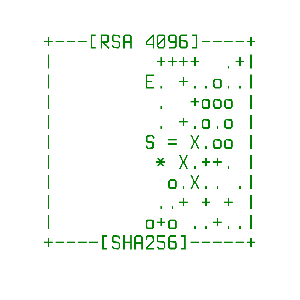

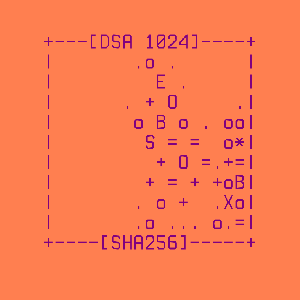

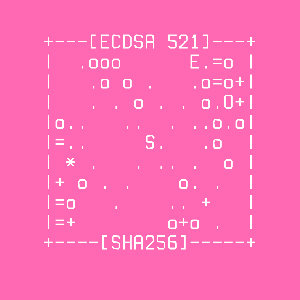

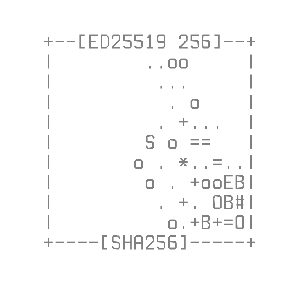

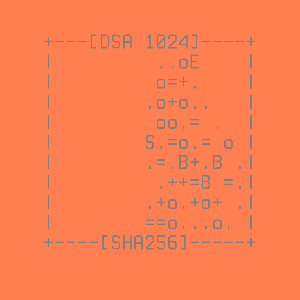

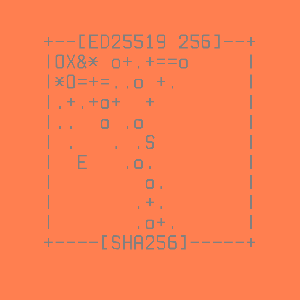

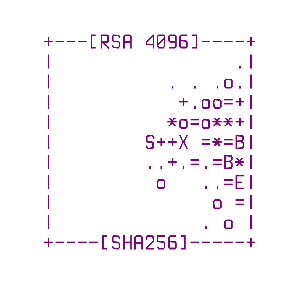

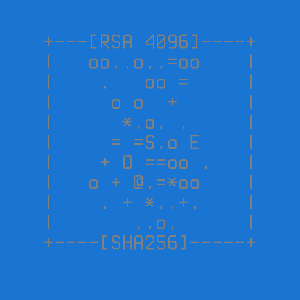

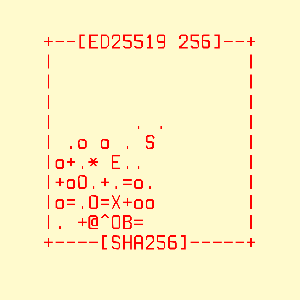

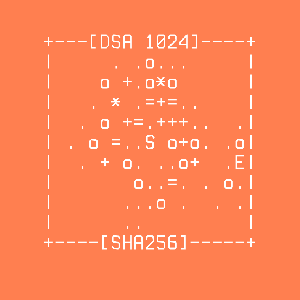

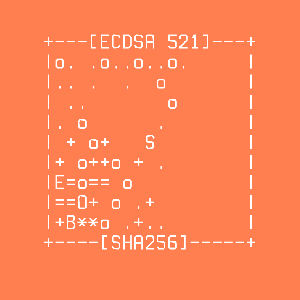

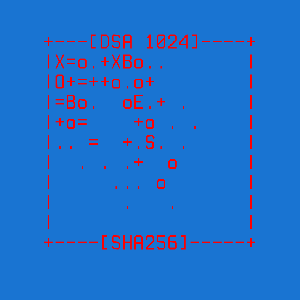

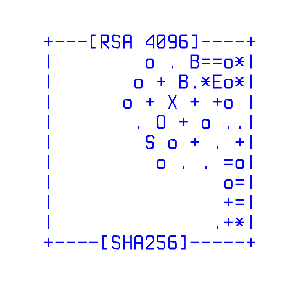

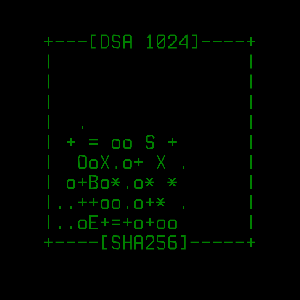

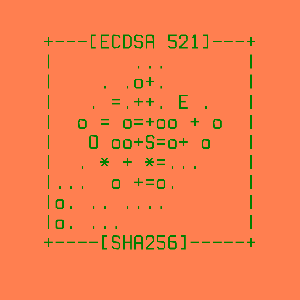

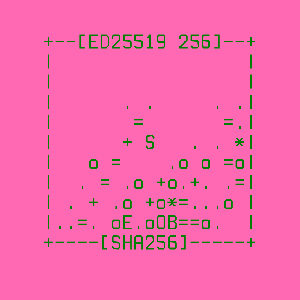

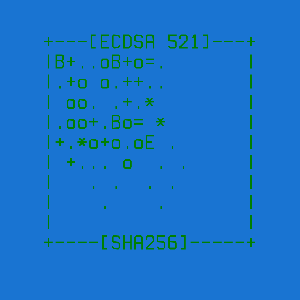

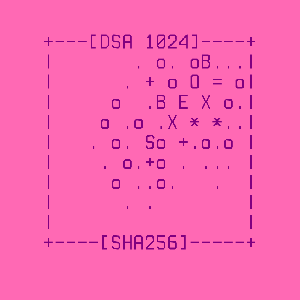

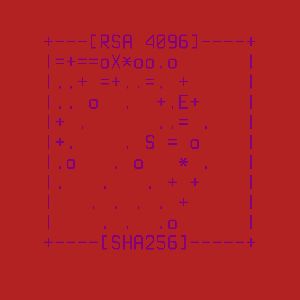

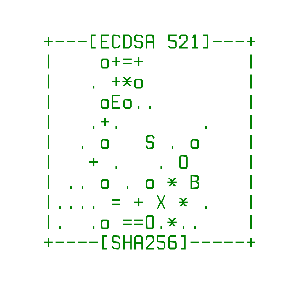

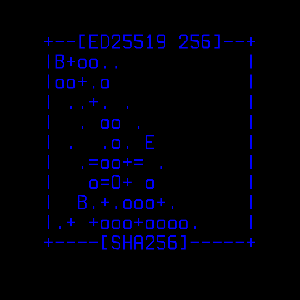

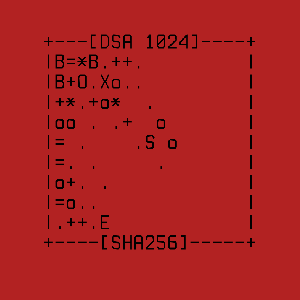

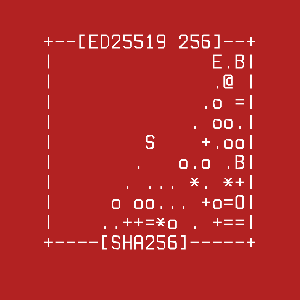

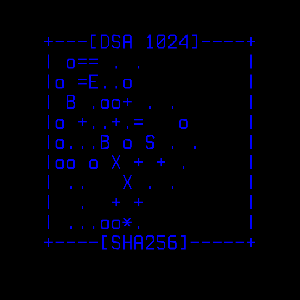

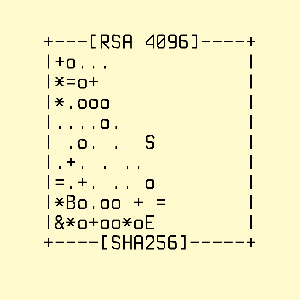

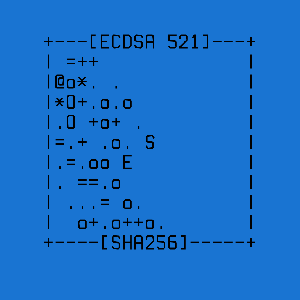

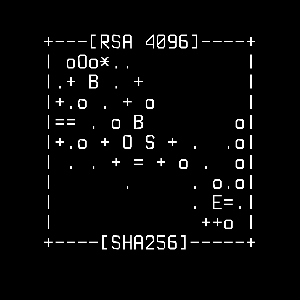

In [14]:
for i, item in enumerate(collection):
    nft = SolKeyNFT(traits=item, idx=i)
    img = Image.open(nft.get_image_path())
    display(img.resize((300, 300), Image.NEAREST))

            

In [24]:
def make_attributes(traits):
    attributes = [{"trait_type": str(trait), "value": str(trait[trait])} for trait in traits]
    return attributes